In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

We create a phase oracle that will mark states (|000⟩ and |111⟩ ) as the results (step 1).

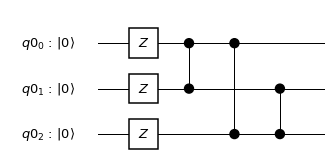

In [2]:
def phase_oracle(circuit, register):
    circuit.z(qr)
    circuit.cz(qr[1],qr[0])
    circuit.cz(qr[2],qr[0])
    circuit.cz(qr[2],qr[1])

qr = QuantumRegister(3)
oracleCircuit = QuantumCircuit(qr)
phase_oracle(oracleCircuit, qr)
oracleCircuit.draw(output="mpl")

Next we set up the circuit for inversion about the average (step 2), where we will first need to define a function that creates a multiple-controlled Z gate.

In [3]:
def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)

In [4]:
def inversion_about_average(circuit, register, n):
    """Apply inversion about the average step of Grover's algorithm."""
    circuit.h(register)
    circuit.x(register)
    n_controlled_Z(circuit, [register[j] for j in range(n-1)], register[n-1])
    circuit.x(register)
    circuit.h(register)

Circuit of the inversion about the average for three qubits.

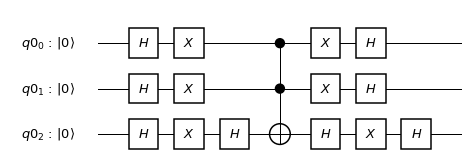

In [6]:
qAverage = QuantumCircuit(qr)
inversion_about_average(qAverage, qr, 3)
qAverage.draw(output='mpl')

Now we put the pieces together, with the creation of a uniform superposition at the start of the circuit and a measurement at the end. Note that since there are two solutions and eight possibilities, we will only need to run one iteration.

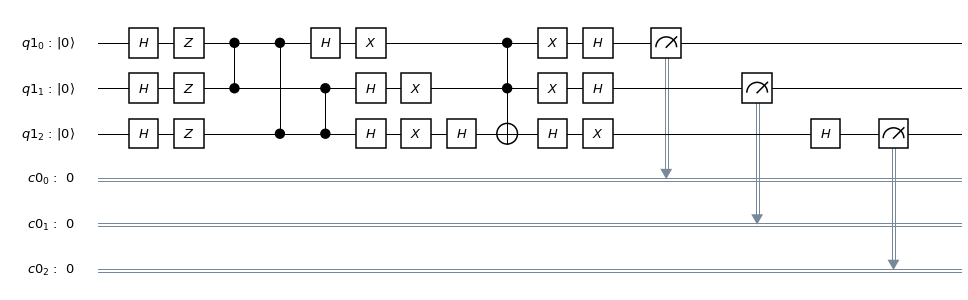

In [7]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

groverCircuit = QuantumCircuit(qr,cr)
groverCircuit.h(qr)

phase_oracle(groverCircuit, qr)
inversion_about_average(groverCircuit, qr, 3)

groverCircuit.measure(qr,cr)
groverCircuit.draw(output="mpl")

In [8]:
# Load our saved IBMQ accounts and get the least busy backend device
IBMQ.load_accounts()
IBMQ.backends()
backend_lb = least_busy(IBMQ.backends(simulator=False))
print("Least busy backend: ", backend_lb)

Least busy backend:  ibmqx2


In [13]:
# run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

backend = backend_lb
shots = 8192
job_exp = execute(groverCircuit, backend=backend, shots=shots)

job_monitor(job_exp, interval = 2)

Job Status: job has successfully run


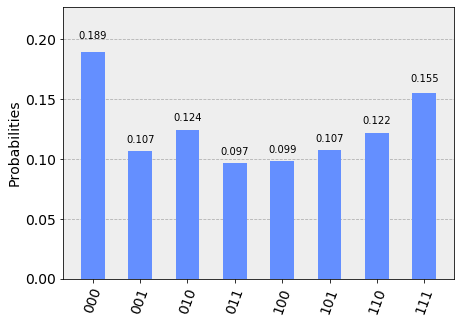

In [14]:
# get the results from the computation
results = job_exp.result()
answer = results.get_counts(groverCircuit)
plot_histogram(answer)